In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wsls_fit import *
from wsls_sim import *

In [2]:
# read dataframe 
df = pd.read_csv('bats_actions_data.csv')
df = df.rename(columns={'ch':'action'})
df = df.rename(columns={'rw':'reward'})

df['action'] = df['action']-1
df['corr_side'] = df['corr_side']-1


In [3]:
all_data = []

#create unique list of names
UniqueNames = df.subj.unique()
UniqueNames.sort()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.subj == key]
    all_data.append(DataFrameDict[key])

all_data_n = []
for i in range(UniqueNames.shape[0]):
    cur = all_data[i]
    cur = cur.reset_index()
    all_data_n.append(cur)
    
all_data = all_data_n


dff = pd.read_csv('2parms_pf_nights_with_env_170522.csv')

label = []
for i, s in enumerate(UniqueNames):
    label.append(dff[dff['subj'] == s]['env'].values[0])

In [4]:
f_wsls = []

for i in range(len(all_data)):
    n_block = all_data[i]['night'].unique()
    f_0 = []
    for b in n_block:
        ten_fit = []
        ll_fit = []
        for _ in range(10):
            cur_df = (all_data[i][all_data[i]['night']==b]).reset_index()
            res = wsls_fit(cur_df,2)
            ten_fit.append(res)
            ll_fit.append(res.fun)
        ten_fit_ll = np.array(ll_fit)
        ii = np.argmin(ten_fit_ll)
        f_0.append(ten_fit[ii])
        
    f_wsls.append(f_0)



In [5]:
p_wsls = []
ll_wsls = []
for i in range(len(all_data)):
    n_block = len(all_data[i]['night'].unique())
    for j in range(n_block):
        p_wsls.append(f_wsls[i][j].x)
        ll_wsls.append(f_wsls[i][j].fun)
        
wsls_pa = np.array(p_wsls)
df_wsls = pd.DataFrame(wsls_pa)
df_wsls = df_wsls.rename(columns={0:'p_win_stay',1:'p_loss_shift'})

In [6]:
df_wsls['env'] = dff['env']
df_wsls['subj'] = dff['subj']
df_wsls['night'] = dff['night']
df_wsls['negLL'] = ll_wsls

In [7]:
df_wsls.to_csv('bats_wsls_fit_14_08.csv')

<AxesSubplot:xlabel='night', ylabel='p_win_stay'>

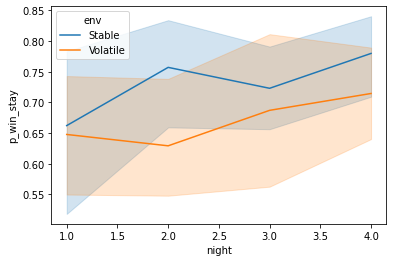

In [8]:
df_wsls.groupby(['env','night']).mean()

sns.lineplot(data=df_wsls,x='night',y='p_win_stay',hue='env')

<AxesSubplot:xlabel='night', ylabel='p_loss_shift'>

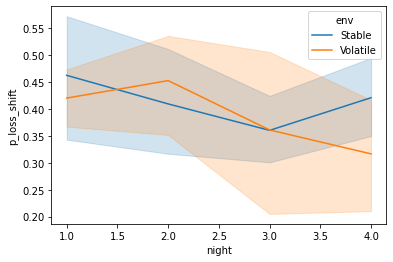

In [9]:
sns.lineplot(data=df_wsls,x='night',y='p_loss_shift',hue='env')

In [10]:
def create_reward_probs_vol(n_action,trials_block,total_trails):
    reward_probs = np.zeros(shape=(n_action,total_trails))
    p_r = np.array([.8,.2])
    for t in range(total_trails):
        if t%13==0:
            p_r = np.flip(p_r)
        reward_probs[:,t] = p_r
    return reward_probs
reward_probs_vol = create_reward_probs_vol(2,13,2000)


def create_reward_probs_stable(n_action,total_trails):
    reward_probs = np.zeros(shape=(n_action,total_trails))
    p_r = np.array([.8,.2])
    counter = 0 
    flag = 1
    for t in range(total_trails):
        counter += 1
        if counter==251 and flag==1:    
            p_r = np.flip(p_r)
            counter = 0
            flag = 2
            
        if counter==214 and flag==2:
            p_r = np.flip(p_r)
            counter = 0
            flag = 1
            
        reward_probs[:,t] = p_r    
    return reward_probs

reward_probs_stable = create_reward_probs_stable(2,2000)


In [ ]:
data_stable = []
data_vol = []

n_agent = 100

num_of_trials = 2000
p_stay = np.linspace(0,1,11)
p_shift = np.linspace(0,1,11)
index = 0 
for p_0 in p_stay:
    for p_1 in p_shift:
        for sim in range(n_agent):
            
            cur_df = wsls_sim([p_0,p_1],num_of_trials,reward_probs_stable)
            cur_df['agent'] = np.repeat(index,num_of_trials)
            data_stable.append(cur_df)
            
            index+=1
            
            cur_df = wsls_sim([p_0,p_1],num_of_trials,reward_probs_vol)
            cur_df['agent'] = np.repeat(index,num_of_trials)
            data_vol.append(cur_df)

df_stable = pd.concat(data_stable)
df_stable.drop(columns=['theta_2','theta_3','theta_4'],inplace=True)
df_stable.rename(columns={'theta_0':'p_stay','theta_1':'p_shift'},inplace=True)
df_stable.to_csv('df_stable_wsls_14_8.csv')


df_vol = pd.concat(data_vol)
df_vol.drop(columns=['theta_2','theta_3','theta_4'],inplace=True)
df_vol.rename(columns={'theta_0':'p_stay','theta_1':'p_shift'},inplace=True)
df_vol.to_csv('df_vol_wsls_14_8.csv')